# **Introduction**
This Jupyter notebook serves as a proof of concept for a view count predictor. The first sections focus on setup and data processing. At the end of the notebook, you can test the predictive model. 

The first step is to introduce several libraries that help with model training.

# **Import Libraries**

In [ ]:
!pip install tensorflow
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import re
import ipywidgets as widgets

# **Import YouTube trending video dataset**
##  "Collected or available datasets"
Retrives records from csv file and puts them into data frame
Only retrieves categoryID, view_count, and tags

In [ ]:
video_df = pd.read_csv('/US_youtube_trending_data_lite.csv', usecols=['categoryId', 'view_count', 'tags'],engine='python', on_bad_lines='skip', header=0)
train_df = video_df

# **Featurizing, Parsing, Cleaning, and Wrangling Datasets**

In [ ]:
# remove empty and/or incomplete rows
values = ['[None]',"[None]",'None']
train_df = train_df[train_df.tags.isin(values) == False]
train_df.dropna()
train_df = train_df.drop(train_df[train_df['tags'] == '[]'].index, axis=0).reset_index(drop=True)
train_df

categoryId                                               tags  \
0              22  brawadis|prank|basketball|skits|ghost|funny vi...   
1              20  Apex Legends|Apex Legends characters|new Apex ...   
2              24  jacksepticeye|funny|funny meme|memes|jacksepti...   
3              10  xxl freshman|xxl freshmen|2020 xxl freshman|20...   
4              26  The LaBrant Family|DIY|Interior Design|Makeove...   
...           ...                                                ...   
37335          20  Clash Royale|Clash Royale Game|Supercell|Super...   
37336          24  sneakerhead|complex|complex originals|sneakers...   
37337          24  Cosmopolitan|Cosmo|ATEEZ|ateez tiktok|ateez ti...   
37338          23  Bootleg merch|merch|Animation|Boot|leg|somethi...   
37339          20  hardcore minecraft|hardcore minecraft 1.17|min...   

       view_count  
0       1514614.0  
1       2381688.0  
2       2038853.0  
3        496771.0  
4       1123889.0  
...           ...  
37335   1471045.0  
37336    489417.0  
37337    309553.0  
37338    647859.0  
37339    262624.0  

[37340 rows x 3 columns]

In [ ]:
# Remove non alphanumeric characters that are also not "|"
# Turn tags string into list of string items
train_df['tags'] = train_df['tags'].apply(lambda word_list: re.sub(r"[^a-zA-Z0-9|]", "",word_list.lower().replace(" ", "")).split('|'))
train_df

categoryId                                               tags  \
0              22  [brawadis, prank, basketball, skits, ghost, fu...   
1              20  [apexlegends, apexlegendscharacters, newapexle...   
2              24  [jacksepticeye, funny, funnymeme, memes, jacks...   
3              10  [xxlfreshman, xxlfreshmen, 2020xxlfreshman, 20...   
4              26  [thelabrantfamily, diy, interiordesign, makeov...   
...           ...                                                ...   
37335          20  [clashroyale, clashroyalegame, supercell, supe...   
37336          24  [sneakerhead, complex, complexoriginals, sneak...   
37337          24  [cosmopolitan, cosmo, ateez, ateeztiktok, atee...   
37338          23  [bootlegmerch, merch, animation, boot, leg, so...   
37339          20  [hardcoreminecraft, hardcoreminecraft117, mine...   

       view_count  
0       1514614.0  
1       2381688.0  
2       2038853.0  
3        496771.0  
4       1123889.0  
...           ...  
37335   1471045.0  
37336    489417.0  
37337    309553.0  
37338    647859.0  
37339    262624.0  

[37340 rows x 3 columns]

# **Building Variables for Model**

In [ ]:
y = train_df.loc[:, 'view_count']
X_raw = train_df.loc[:, 'tags']

In [ ]:
X_raw

0        [brawadis, prank, basketball, skits, ghost, fu...
1        [apexlegends, apexlegendscharacters, newapexle...
2        [jacksepticeye, funny, funnymeme, memes, jacks...
3        [xxlfreshman, xxlfreshmen, 2020xxlfreshman, 20...
4        [thelabrantfamily, diy, interiordesign, makeov...
                               ...                        
37335    [clashroyale, clashroyalegame, supercell, supe...
37336    [sneakerhead, complex, complexoriginals, sneak...
37337    [cosmopolitan, cosmo, ateez, ateeztiktok, atee...
37338    [bootlegmerch, merch, animation, boot, leg, so...
37339    [hardcoreminecraft, hardcoreminecraft117, mine...
Name: tags, Length: 37340, dtype: object

In [ ]:
word_counts = {}
stopwords = ['[None]', '',' ']
for word_list in X_raw:
    for word in word_list:
        if word not in stopwords:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

In [ ]:
word_counts_sorted = {key: value for key, value in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
#word_counts_sorted

In [ ]:
vocabulary = list(word_counts_sorted)[:500]
for word_list in X_raw:
    word_list[:] = [word for word in word_list if word in vocabulary]
X_raw

0        [prank, basketball, skits, funnyvideos, vlog, ...
1                                           [battleroyale]
2                    [funny, memes, reaction, react, meme]
3                      [polog, rapper, rap, hiphop, music]
4                                                    [diy]
                               ...                        
37335                                                   []
37336                       [complex, news, entertainment]
37337                                          [celebrity]
37338    [animation, funny, comedy, skit, music, rap, h...
37339                                                   []
Name: tags, Length: 37340, dtype: object

In [31]:
null_indices = set()

for i, words in tqdm(enumerate(X_raw)):
    if not words:
        null_indices.add(i)
X_raw = X_raw.drop(null_indices, axis=0).reset_index(drop=True)
y = y.drop(null_indices, axis=0).reset_index(drop=True)

37340it [00:00, 249415.64it/s]


# Remove null rows and reset index

In [32]:
null_indices = set()
for i, words in tqdm(enumerate(X_raw)):
    if not words:
        null_indices.add(i)
word_column_names = []
for word_list in tqdm(X_raw):
    for word in word_list:
        if word not in word_column_names:
            word_column_names.append(word)

28544it [00:00, 330297.33it/s]
100%|██████████| 28544/28544 [00:01<00:00, 18493.89it/s]


In [33]:
mlb = MultiLabelBinarizer()

X = pd.DataFrame(mlb.fit_transform(X_raw), columns=word_column_names)

In [34]:
X

prank  basketball  skits  funnyvideos  vlog  vlogging  nba  challenges  \
0          0           0      0            0     0         0    0           0   
1          0           0      0            0     0         0    0           0   
2          0           0      0            0     0         0    0           0   
3          0           0      0            0     0         0    0           0   
4          0           0      0            0     0         0    0           0   
...      ...         ...    ...          ...   ...       ...  ...         ...   
28539      0           0      0            0     0         0    0           0   
28540      0           0      0            0     0         0    0           0   
28541      0           0      0            0     0         0    0           0   
28542      0           0      0            0     0         0    0           0   
28543      0           0      0            0     0         0    0           0   

       fazerug  battleroyale  ...  chasehudson  minecraftbut  dreamminecraft  \
0            0             0  ...            0             0               0   
1            0             0  ...            0             0               0   
2            0             0  ...            0             0               0   
3            0             0  ...            0             0               0   
4            0             0  ...            0             0               0   
...        ...           ...  ...          ...           ...             ...   
28539        0             0  ...            0             0               0   
28540        0             0  ...            0             0               0   
28541        0             0  ...            0             0               0   
28542        0             0  ...            0             0               0   
28543        0             0  ...            0             0               0   

       minecraftchallenge  halloween  s46  dreamsmp  midrange  202021season  \
0                       0          0    0         0         0             0   
1                       0          0    0         0         0             0   
2                       0          0    0         0         0             0   
3                       0          0    0         0         0             0   
4                       0          0    0         0         0             0   
...                   ...        ...  ...       ...       ...           ...   
28539                   0          0    0         0         0             0   
28540                   0          0    0         0         0             0   
28541                   0          0    0         0         0             0   
28542                   0          0    0         0         0             0   
28543                   0          0    0         0         0             0   

       fadeaway  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
28539         0  
28540         0  
28541         0  
28542         0  
28543         0  

[28544 rows x 500 columns]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=24)
X.shape

(28544, 500)

# **Create and Train Data Model**

In [36]:
inputs = tf.keras.Input(shape=(500,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='mean_squared_logarithmic_error'
)


batch_size = 20
epochs = 70

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

Epoch 1/70
229/229 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/70
229/229 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 3/70
229/229 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 4/70
229/229 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 5/70
229/229 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 6/70
229/229 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 7/70
229/229 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 8/70
229/229 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 9/70
229/229 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 10/70
229/229 [================

In [37]:
hist_fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "Epoch", 'y': "Loss"},
    title="Loss Over Time"
)

hist_fig.show()

# **Outcome Accuarcy**

In [38]:
np.argmin(history.history['val_loss'])

0

In [39]:
model.evaluate(X_test, y_test)

714/714 [==============================] - 1s 1ms/step - loss: nan


nan

In [40]:
y_preds = model.predict(X_test)
y_test

25565    1119223.0
12870     541038.0
21775    7075953.0
16022    1372425.0
16354     258347.0
           ...    
12153    1855531.0
23987     868723.0
23998    9755203.0
4314      706592.0
20632    7808983.0
Name: view_count, Length: 22836, dtype: float64

In [41]:
#Determine Accuracy
# 1 is excelent
r2_score(y_test, model.predict(X_test))

ValueError: ignored

In [42]:
pca = PCA(n_components=2)
X_reduced = pd.DataFrame(pca.fit_transform(X), columns=["PC1", "PC2"])
word_lists = []

for row in X_reduced.iterrows():
    word_list = [word for word in X.columns if X.loc[row[0], word] == 1]
    word_lists.append(word_list)
X_reduced['keywords'] = word_lists
X_reduced['keywords'] = X_reduced['keywords'].astype(str)

# **Non-Descriptive / Analytics**
Tags are organized by highest average views of videos accosiated with this tag

In [43]:
# convert dictionary to dataframe
word_count_df = pd.DataFrame(list(word_counts_sorted.items()), columns = ['tag','frequency'])
word_count_df = word_count_df.head(500)
word_count_df['tags'] = word_count_df.tag
word_count_df = word_count_df.merge(train_df.explode('tags'),how='left')
word_count_df['view_avg'] = word_count_df.groupby('tag')['view_count'].transform('mean')
del word_count_df['tags']
word_count_df.sort_values('2')

KeyError: ignored

In [44]:
corrMap = word_count_df.corr()
category_fig  = go.Figure()
category_fig.add_trace(
    go.Heatmap(
        x = corrMap.columns,
        y = corrMap.index,
        z = np.array(corrMap),
        text=corrMap.values,
        texttemplate='%{text:.2f}'
    )
)
category_fig.show()

In [45]:
scatter_fig = px.scatter(
    X_reduced,
    x='PC1',
    y='PC2',
    trendline="ols",
    hover_data={
        'PC1': False,
        'PC2': False,
        'keywords': True
    }
)
scatter_fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# **Descriptive Methods / Data Visualization**

In [46]:
word_count_fig  = px.scatter(word_count_df, x="view_avg",y="tag")
word_count_fig.show()

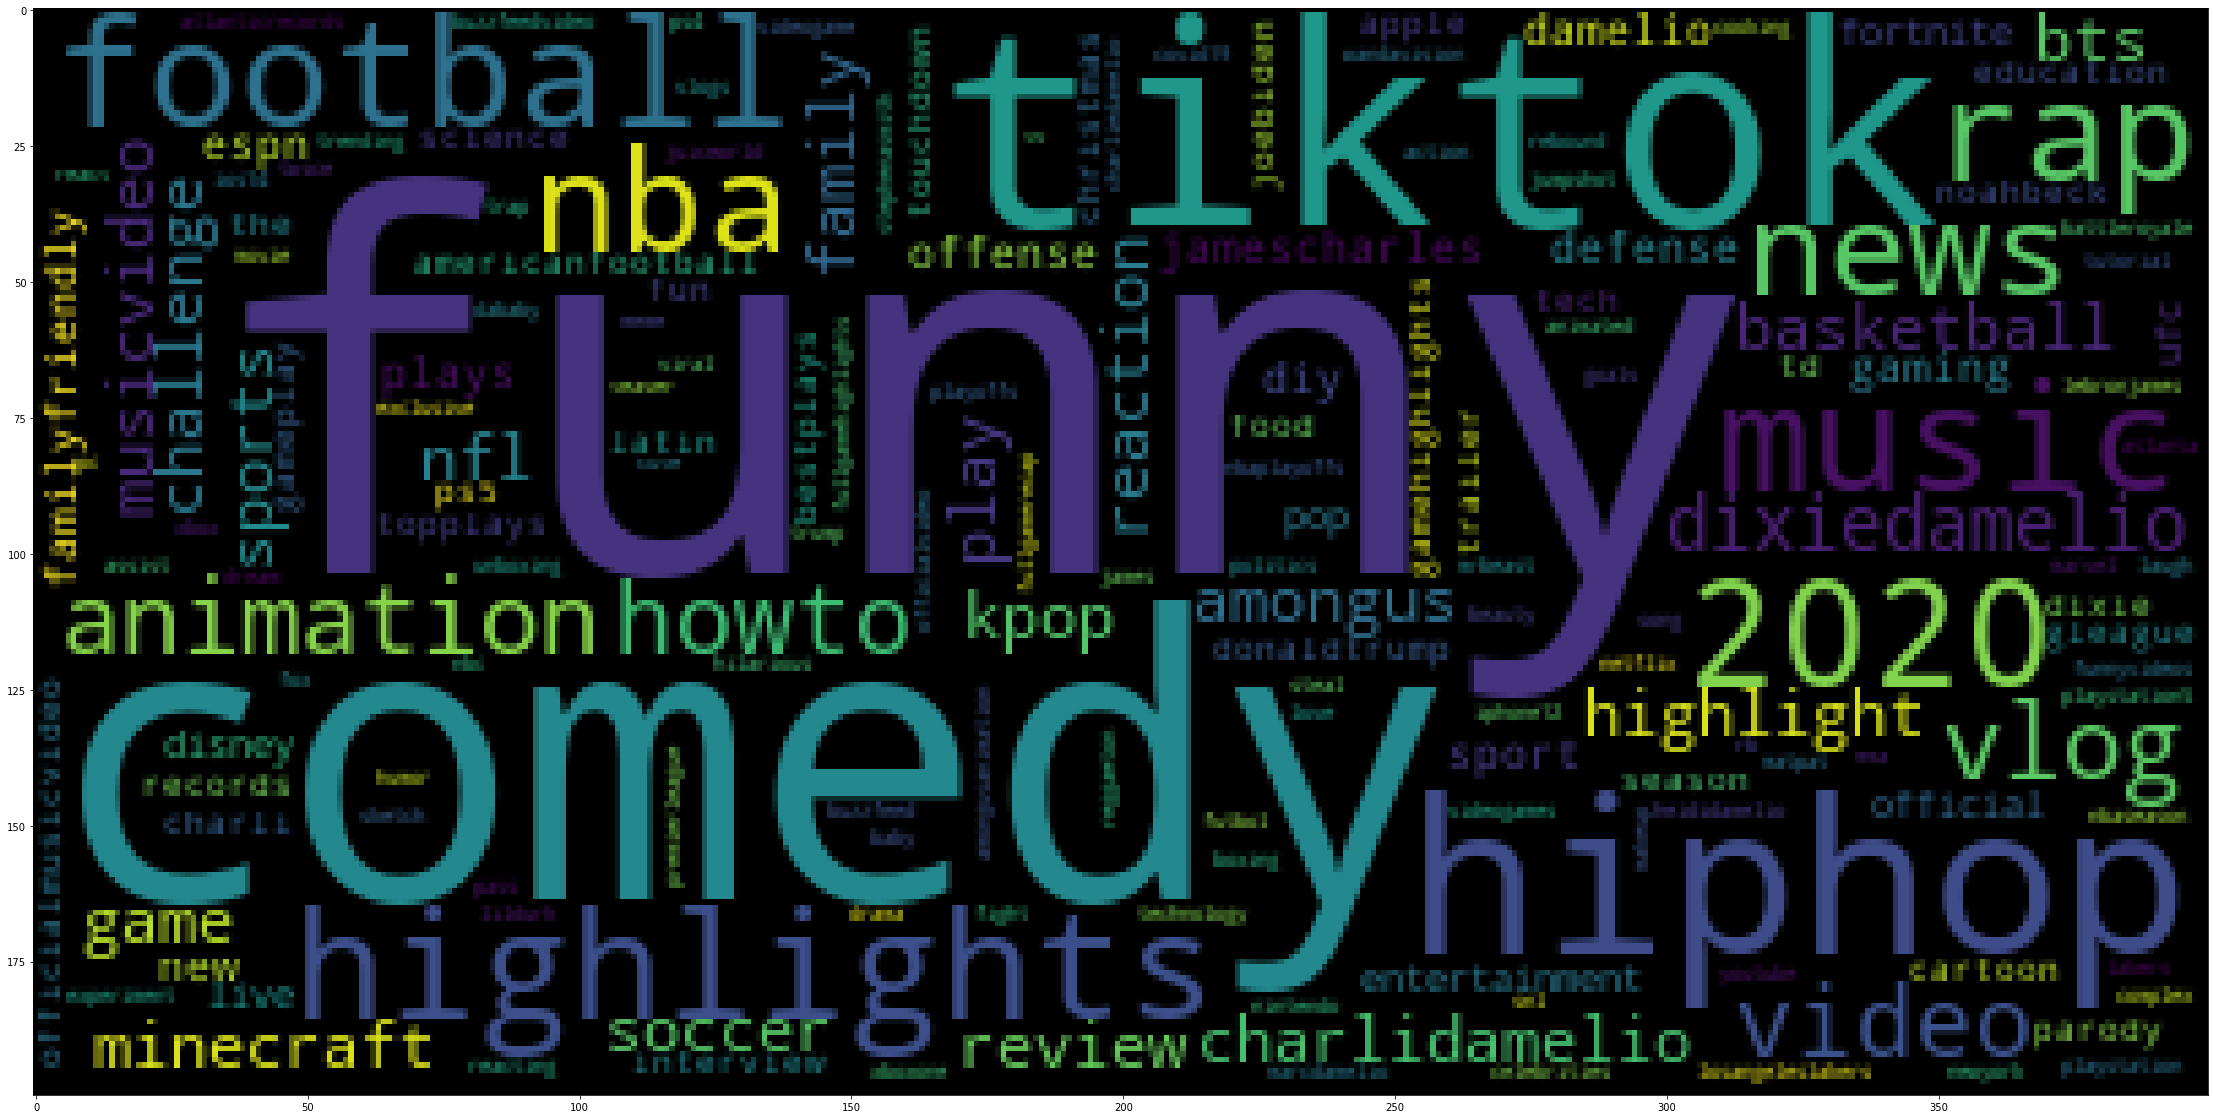

In [47]:
wc = WordCloud().generate_from_frequencies(word_counts_sorted)

plt.figure(figsize=(100,20))
plt.subplot(1,2,1)
plt.imshow(wc)

# **Interactive Widget**

In [48]:
# importing the module
import json
 
# Opening JSON file

with open('/US_category_id.json') as json_file:
    categories = json.load(json_file)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
word_count_df['category_name'] = word_count_df['categoryId'].map(cat_dict)
word_count_df

FileNotFoundError: ignored

In [49]:
categors = list(cat_dict.values())
# category dropdown
cat_drop= widgets.SelectMultiple(
    options= categors ,
    #rows=10,
    description='Video Categories',
    disabled=False
)

#tag 1
tag1_filter = [] 
for i in word_count_df.loc[df['category_name'] == cat_drop.value]: 
    if i not in result: 
        result.append(i)
tag1 = widgets.SelectMultiple(
    options= tag1_filter,
    #rows=10,
    description='Video Categories',
    disabled=False
)
#tag 2
tag2_filter = tag1_filter 
tag2_filter.remove(tag1.value)
tag2 = widgets.SelectMultiple(
    options= tag2_filter,
    #rows=10,
    description='Video Categories',
    disabled=False
)

NameError: ignored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
#
# This file is autogenerated by pip-compile with python 3.7
# To update, run:
#
#    pip-compile requirements.txt
#
--extra-index-url https://us-python.pkg.dev/colab-wheels/public/simple/



SyntaxError: ignored